#  Trees and Calibration



## The Dataset

### Description
This dataset contains details of individual relating to their health. The target is stored in **strokes** column which is binary variable indicating either 0 or 1. The goal of the assignment is a binary classification task to predict wether the person will get a stroke depending on other health factors

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import time


from sklearn import tree

## Decision Trees

**1.1: Load the provided dataset**

In [3]:
#
df = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')
df

id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  formerly smoked   
1     Self-employed          Rural             202.21   NaN     never smoked   
2           Private          Rural             105.92  32.5     never smoked   
3           Private          Urban             171.23  34.4           smokes   
4     Self-employed          Rural             174.12  24.0     never smoked   
...             ...            ...                ...   ...              ...   
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
5105       0  
5106       0  
5107       0  
5108       0  
5109       0  

[5110 rows x 12 columns]

Text(0.5, 1.0, 'Percentage of Missing values in each column')

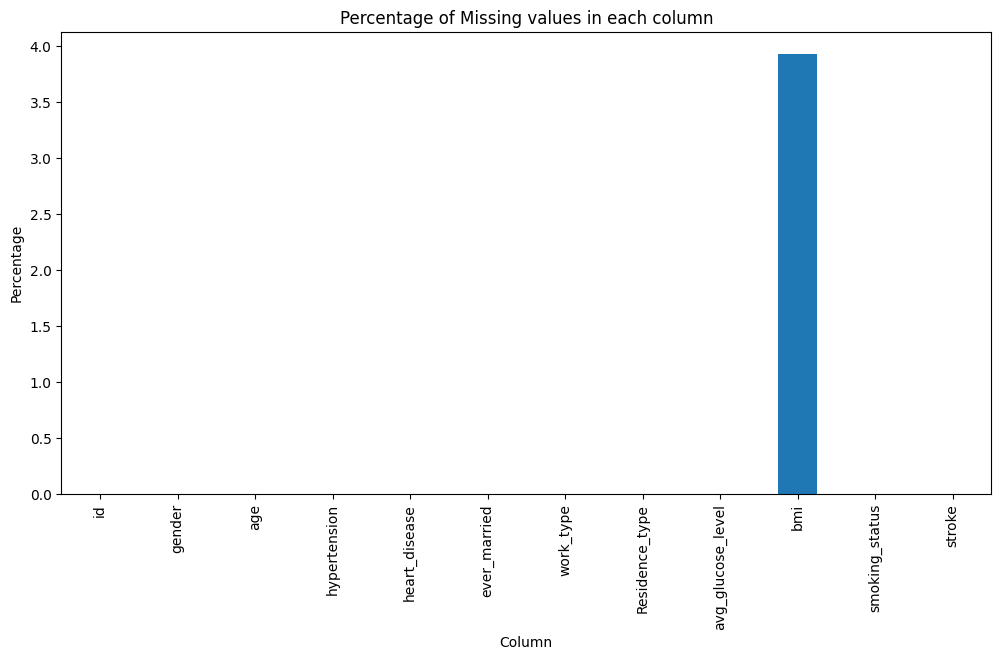

In [4]:

missing = df.isnull().sum()
missing_percentage = (missing/len(df))*100

missing_percentage.plot.bar(figsize=(12,6))
plt.ylabel("Percentage")
plt.xlabel("Column")
plt.title("Percentage of Missing values in each column")

In [5]:
df_clean=df.dropna()
df_clean.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

I would not replace any value with mean as decision tree is not very sensitive to missing values and as the percentage of missing values is less, so I would prefer dropping them.

**Check for the number of rows after handling null values, each column should have the same number of non-null count**

In [6]:
#

print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   object 
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   object 
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   object 
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 498.6+ KB
None


<Axes: xlabel='stroke', ylabel='Count'>

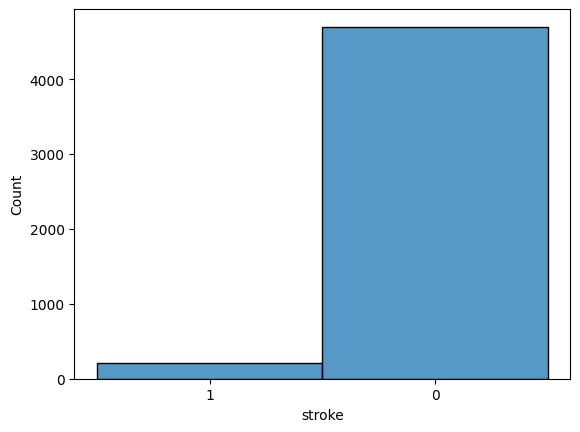

In [7]:
#
target1= df_clean['stroke'].apply(str)
sns.histplot(data=df_clean, x=target1,  binwidth=1, discrete = True)

#No it is an unbalanced dataset


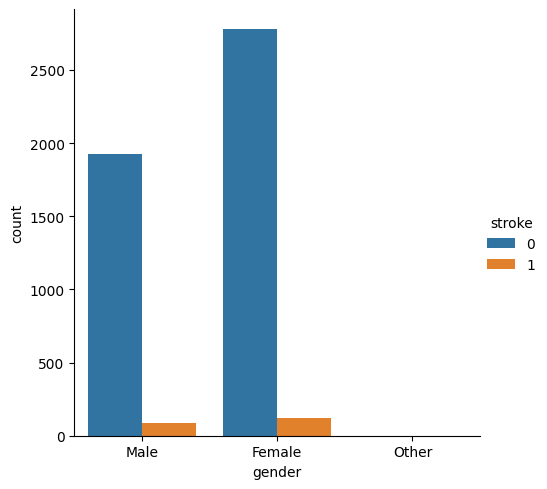

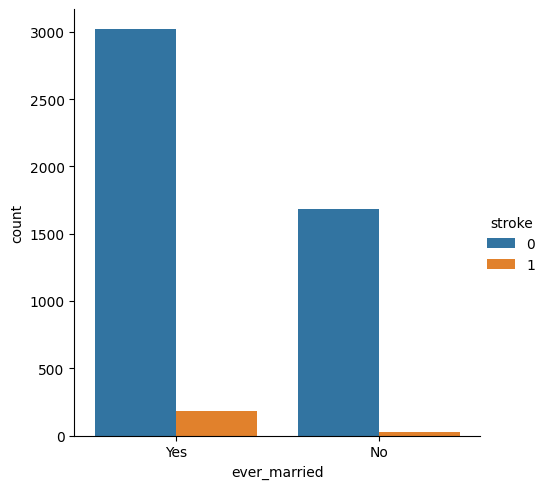

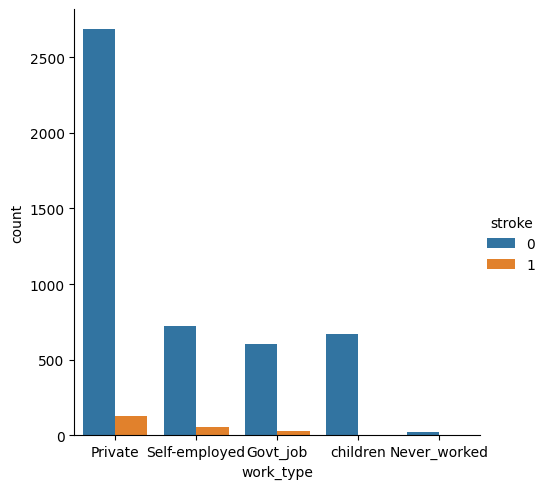

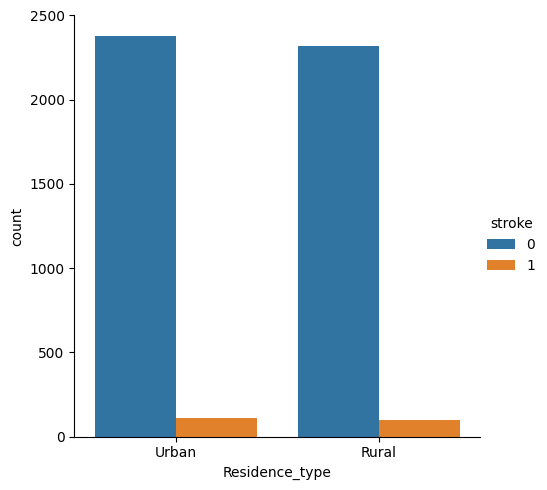

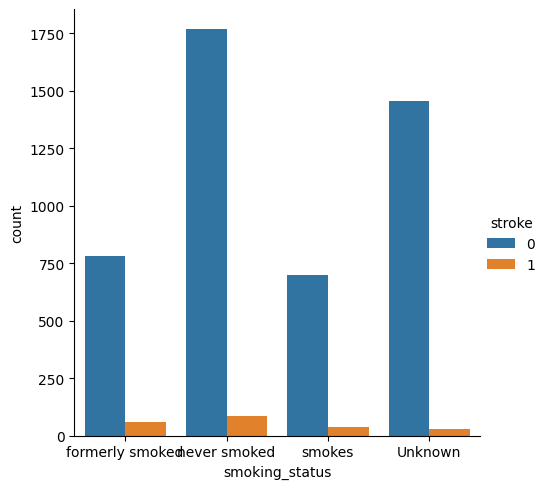

In [8]:


object_col = df_clean.select_dtypes(include=['object']).columns
df_clean['stroke'] = df_clean['stroke'].astype('object')

for column in object_col:
    sns.catplot(data=df_clean,x= column,hue= 'stroke', kind = 'count')




In [9]:
df_X = df_clean.drop(columns=['stroke','id'])
df_Y = df_clean['stroke'].astype(int)

#


In [10]:
a = (df_X.dtypes == 'object')
object_col = list(a[a].index)
print(object_col)

OHE_data = pd.get_dummies(df_X, columns=object_col,dtype = float, drop_first=True)
OHE_data
#ordinal encoding of smoking_status

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
0     67.0             0              1             228.69  36.6          1.0   
2     80.0             0              1             105.92  32.5          1.0   
3     49.0             0              0             171.23  34.4          0.0   
4     79.0             1              0             174.12  24.0          0.0   
5     81.0             0              0             186.21  29.0          1.0   
...    ...           ...            ...                ...   ...          ...   
5104  13.0             0              0             103.08  18.6          0.0   
5106  81.0             0              0             125.20  40.0          0.0   
5107  35.0             0              0              82.99  30.6          0.0   
5108  51.0             0              0             166.29  25.6          1.0   
5109  44.0             0              0              85.28  26.2          0.0   

      gender_Other  ever_married_Yes  work_type_Never_worked  \
0              0.0               1.0                     0.0   
2              0.0               1.0                     0.0   
3              0.0               1.0                     0.0   
4              0.0               1.0                     0.0   
5              0.0               1.0                     0.0   
...            ...               ...                     ...   
5104           0.0               0.0                     0.0   
5106           0.0               1.0                     0.0   
5107           0.0               1.0                     0.0   
5108           0.0               1.0                     0.0   
5109           0.0               1.0                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
0                   1.0                      0.0                 0.0   
2                   1.0                      0.0                 0.0   
3                   1.0                      0.0                 0.0   
4                   0.0                      1.0                 0.0   
5                   1.0                      0.0                 0.0   
...                 ...                      ...                 ...   
5104                0.0                      0.0                 1.0   
5106                0.0                      1.0                 0.0   
5107                0.0                      1.0                 0.0   
5108                1.0                      0.0                 0.0   
5109                0.0                      0.0                 0.0   

      Residence_type_Urban  smoking_status_formerly smoked  \
0                      1.0                             1.0   
2                      0.0                             0.0   
3                      1.0                             0.0   
4                      0.0                             0.0   
5                      1.0                             1.0   
...                    ...                             ...   
5104                   0.0                             0.0   
5106                   1.0                             0.0   
5107                   0.0                             0.0   
5108                   0.0                             1.0   
5109                   1.0                             0.0   

      smoking_status_never smoked  smoking_status_smokes  
0                             0.0                    0.0  
2                             1.0                    0.0  
3                             0.0                    1.0  
4                             1.0                    0.0  
5                             0.0                    0.0  
...                           ...                    ...  
5104                          0.0                    0.0  
5106                          1.0                    0.0  
5107                          1.0                    0.0  
5108                          0.0                    0.0  
5109  

Decision trees are a greedy method that depend on the relationship between features within the data rather than their values. So they are not sensitive to data scaling thus we dont need to scale the data.

**Split the data into development and test datasets. Which splitting methodology did you choose and why?**

In [11]:
#Stratifying the dataset as it is imbalanced
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(OHE_data,df_Y, test_size=0.2, stratify=df_Y,random_state=23)


I choose to used staritified split as the dataset is very unbalanced.

**Fitting a Decision Tree on the training data until all leaves are pure.**

Accuracy 0.9103869653767821
Precision 0.12903225806451613
Recall 0.19047619047619047
F1-score 0.15384615384615383


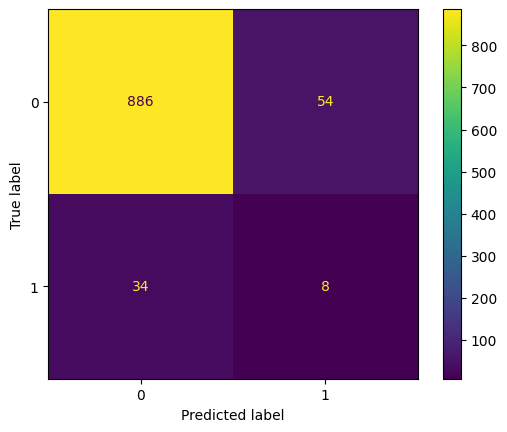

In [12]:
#Until all leaves are pure DO

model = DecisionTreeClassifier()
clf = model.fit(df_X_train,df_y_train)
df_y_pred = model.predict(df_X_test)

accuracy_1= accuracy_score(df_y_test,df_y_pred)
precision_1 = precision_score(df_y_test,df_y_pred)
recall_1 = recall_score(df_y_test,df_y_pred)
f1_score_1 = f1_score(df_y_test, df_y_pred)

con_1 = confusion_matrix(df_y_test, df_y_pred)

print("Accuracy",accuracy_1)
print("Precision",precision_1)
print("Recall",recall_1)
print("F1-score", f1_score_1)

ConfusionMatrixDisplay(confusion_matrix=con_1).plot();

I believe the most relevant metric is Recall as it is extremely important to predict if a person is having a stroke, that is a true positive is essential.

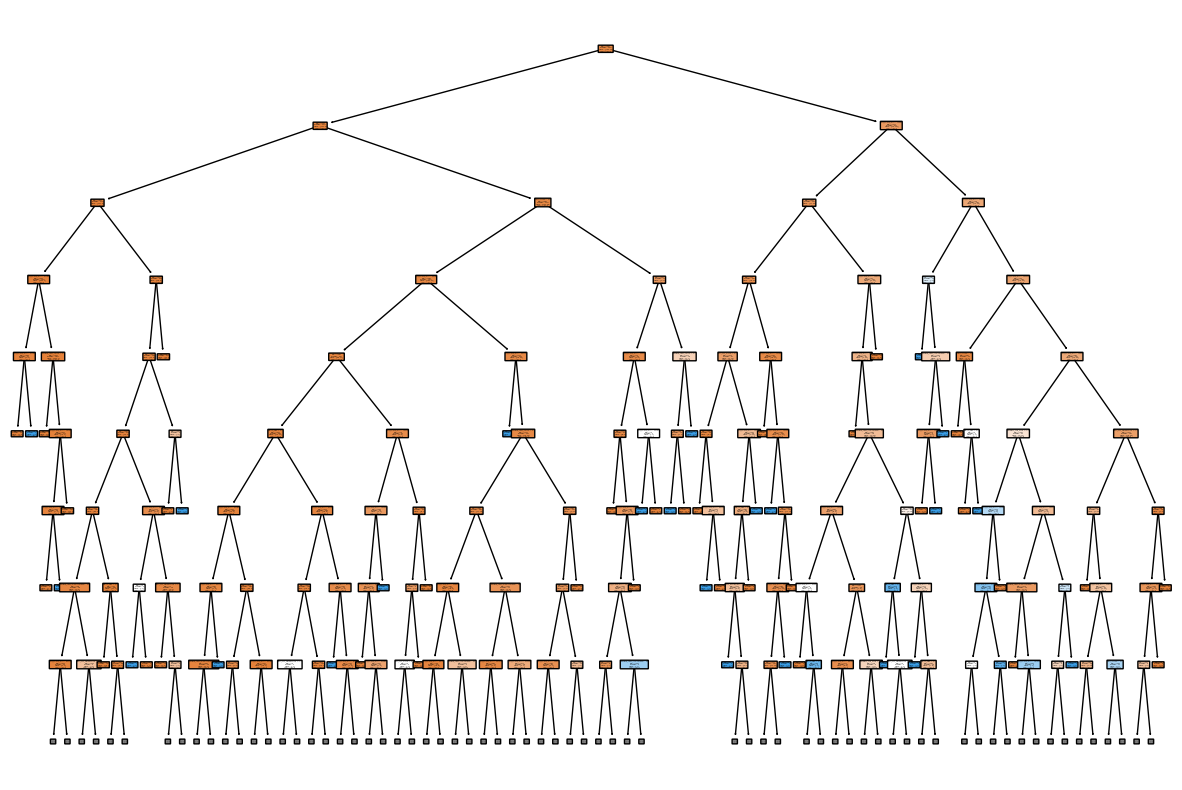

In [13]:


feature_names = OHE_data.columns.tolist()


plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree = clf, max_depth = 8, feature_names = feature_names, class_names =['Class_0', 'Class_1'], filled = True, rounded = True)
plt.show()

Best Parameters {'ccp_alpha': 0.0004, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}
Accuracy 0.9460285132382892
Precision 0.17647058823529413
Recall 0.07142857142857142
F1-score 0.10169491525423728


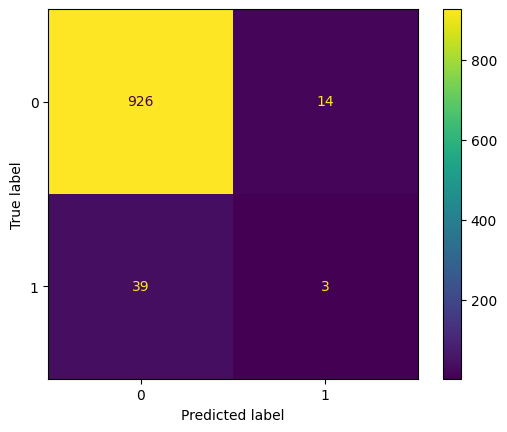

In [14]:
## YOU
param_grid_clf = { 
    'ccp_alpha':[0.1, 0.0002, 0.0004],
    'max_depth': [None, 10, 23],
    'min_samples_split': [None,10,23],
    'min_samples_leaf': [None,5,15],
}

grid_search_clf = GridSearchCV(estimator= clf, param_grid = param_grid_clf, cv= 5, scoring = 'recall', n_jobs = -1)
grid_search_clf.fit(df_X_train, df_y_train)

best_parameters_clf = grid_search_clf.best_params_
best_clf = grid_search_clf.best_estimator_

print("Best Parameters", best_parameters_clf)


best_clf.fit(df_X_train, df_y_train)
clf_Y_pred_b = best_clf.predict(df_X_test)

accuracy_clf= accuracy_score(df_y_test,clf_Y_pred_b)
precision_clf = precision_score(df_y_test,clf_Y_pred_b)
recall_clf= recall_score(df_y_test,clf_Y_pred_b)
f1_score_clf = f1_score(df_y_test, clf_Y_pred_b)

con_clf = confusion_matrix(df_y_test, clf_Y_pred_b)

print("Accuracy",accuracy_clf)
print("Precision",precision_clf)
print("Recall",recall_clf)
print("F1-score", f1_score_clf)

ConfusionMatrixDisplay(confusion_matrix=con_clf).plot();

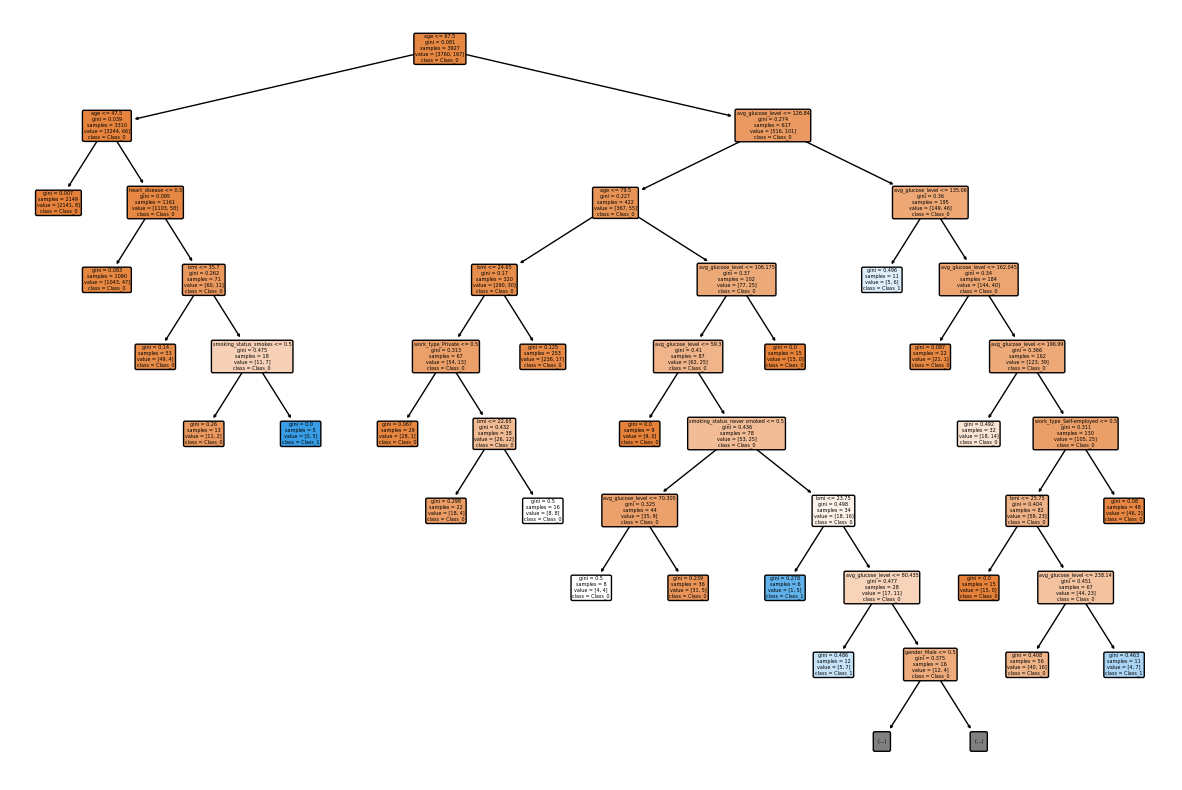

In [15]:
#

feature_names = OHE_data.columns.tolist()

plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree = best_clf, max_depth = 8, feature_names = feature_names, class_names =['Class_0', 'Class_1'], filled = True, rounded = True)
plt.show()

I choose ccp_alpha as the pruning factor to avoid overfitting. due to the dataset being unbalanced and decision tree having a tendency to overfit, cost complexity prunning prevents overfitting of data, I also changed factors like min samples split, min samples leaf and max depth to get the optimal results

The three most important features are: ['age', 'avg_glucose_level', 'bmi']


<Axes: >

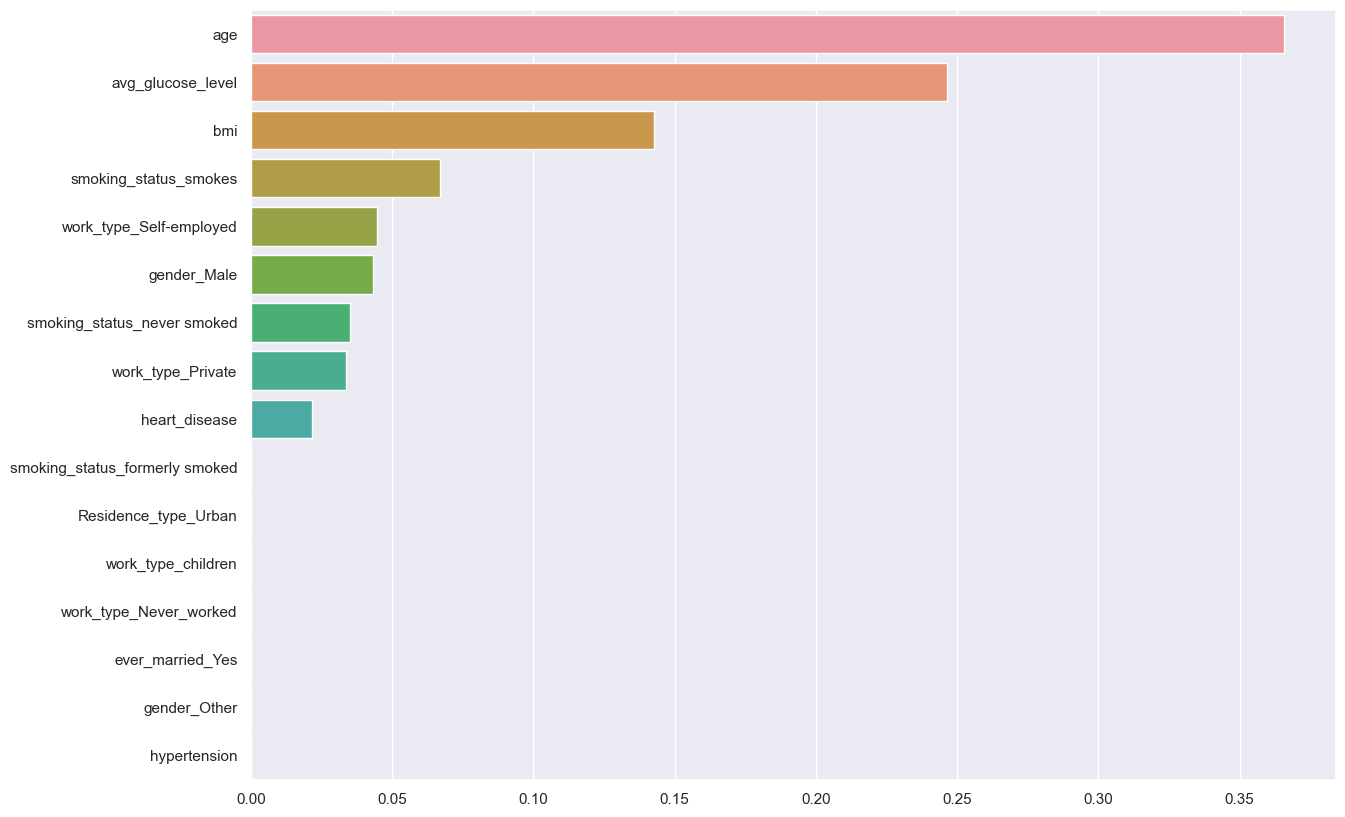

In [16]:

feature_importance = best_clf.feature_importances_
sorted_features = np.argsort(feature_importance)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_features]
sorted_importances = feature_importance[sorted_features]

most_important_features = [feature_names[i] for i in sorted_features[:3]]

print("The three most important features are:", most_important_features)

sns.set(rc={'figure.figsize':(14,10)})
sns.barplot(x = sorted_importances, y = sorted_feature_names)



The top three most important features sorted through the above code are age, avg_glucose_level and bmi. However it must be kept in mind that decision tree tends to undervalue the importance of categorical variables like gender, work type, married  etc. as they divide the input over categories.

## Random Forests

Accuracy: 0.9572301425661914
Precision: 0.5
Recall: 0.023809523809523808
F1-score 0.04545454545454545


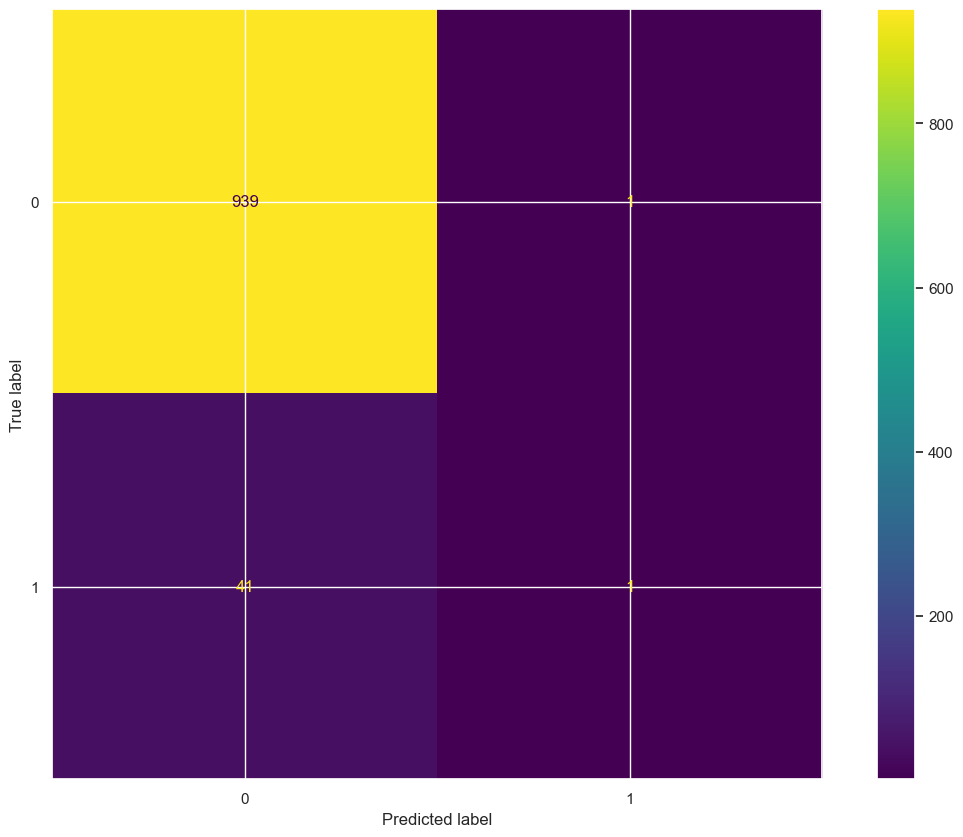

In [17]:
# 

rf = RandomForestClassifier()

rf.fit(df_X_train, df_y_train)
rf_Y_pred = rf.predict(df_X_test)

accuracy_rf = accuracy_score(df_y_test, rf_Y_pred)
precision_rf = precision_score(df_y_test, rf_Y_pred)
recall_rf= recall_score(df_y_test, rf_Y_pred)
f1_score_rf = f1_score(df_y_test, rf_Y_pred)

print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-score", f1_score_rf)

con_rf = confusion_matrix(df_y_test, rf_Y_pred)

ConfusionMatrixDisplay(confusion_matrix=con_rf).plot();

Yes all leaves are pure

In [18]:
## Verifcation
for i , tree in enumerate (rf.estimators_):
    leaf = 0
    pure_leaves = 0
    for node_id in range(tree.tree_.node_count):
        if tree.tree_.children_left[node_id] == tree.tree_.children_right[node_id]:
            leaf+=1
            if tree.tree_.impurity[node_id] <= 0:
                pure_leaves+=1
if pure_leaves == leaf:
    print("Yes all leaves are pure")

Yes all leaves are pure


This can be verified by seeing if all the nodes are pure 

In [19]:
#

weight_choice = [
    {0:1, 1:1},
    {0:1, 1:2},
    {0:1, 1:3},
    {0:1, 1:4},
    {0:1, 1:5}
]
param_grid = {
    'max_depth' : [None, 10, 23],
    'class_weight' : weight_choice,
    'random_state': [45]
}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs=-1, scoring = 'recall')

grid_search.fit(df_X_train, df_y_train)

best_parameters_rf = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Best Parameters", best_parameters_rf)


Best Parameters {'class_weight': {0: 1, 1: 1}, 'max_depth': None, 'random_state': 45}


As the dataset is imbalanced, I would choose class_weights and max_depth. class_weights to assign different weight to certain output and max_depth to prevent overfitting as is customary in unbalanced sets.

I would choose them in the range of the selected values to give the best possible result

In [20]:
## YOUR ANSWER HERE
weight_choice2 = [
    {0:1, 1:1},
    {0:2, 1:1},
    {0:5, 1:1},
    {0:3, 1:1},
    {0:4, 1:1},
    
   
]
param_grid2 = {
    'max_depth' : [None,8,9, 10, 11],
    'class_weight' : weight_choice2,
    'random_state': [45]
}
grid_search_rfb = GridSearchCV(estimator = rf, param_grid = param_grid2, n_jobs=-1, scoring = 'recall')

grid_search_rfb.fit(df_X_train, df_y_train)

best_parameters_rfb = grid_search_rfb.best_params_
best_rfb = grid_search_rfb.best_estimator_

print("Best Parameters", best_parameters_rfb)


Best Parameters {'class_weight': {0: 2, 1: 1}, 'max_depth': None, 'random_state': 45}


Accuracy: 0.9562118126272913
Precision: 0.3333333333333333
Recall: 0.023809523809523808
F1-score: 0.044444444444444446


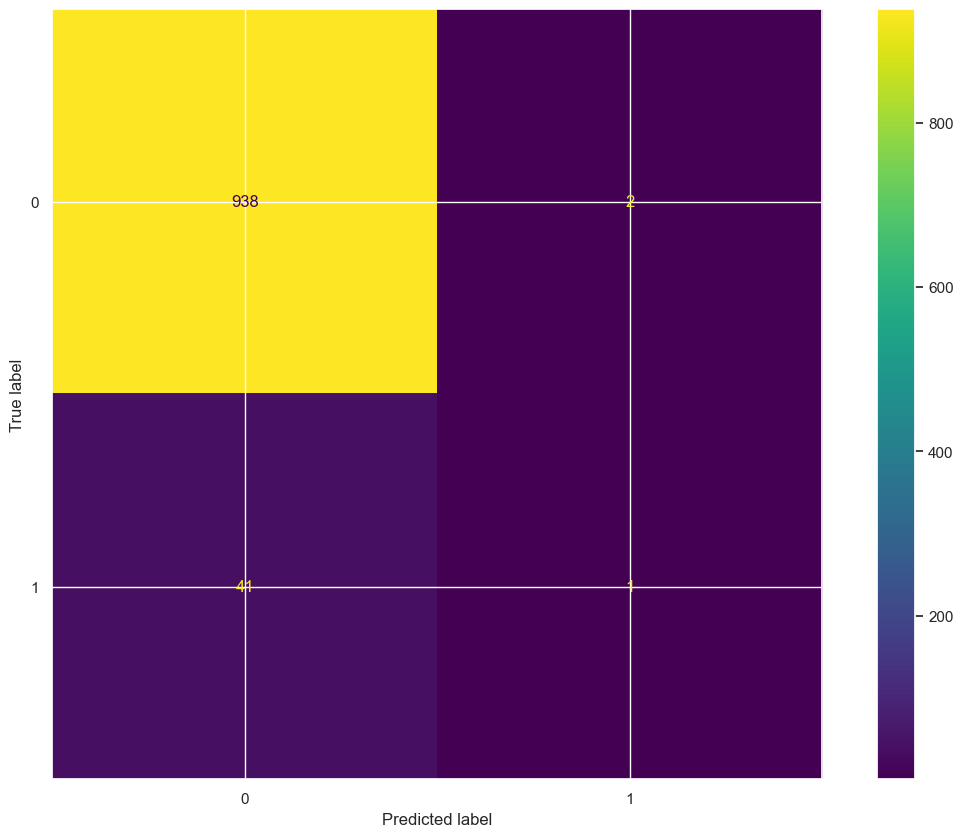

In [21]:

best_rfb.fit(df_X_train, df_y_train)
rf_Y_pred_b = best_rfb.predict(df_X_test)

accuracy_rfb = accuracy_score(df_y_test, rf_Y_pred_b)
precision_rfb = precision_score(df_y_test, rf_Y_pred_b)
recall_rfb = recall_score(df_y_test, rf_Y_pred_b)
f1_score_rfb = f1_score(df_y_test, rf_Y_pred_b)

print("Accuracy:", accuracy_rfb)
print("Precision:", precision_rfb)
print("Recall:", recall_rfb)
print("F1-score:", f1_score_rfb)

con_rfb = confusion_matrix(df_y_test, rf_Y_pred_b)

ConfusionMatrixDisplay(confusion_matrix=con_rfb).plot();

No the performance hasn't had a significant change.

The three most important features are: ['avg_glucose_level', 'bmi', 'age']


<Axes: >

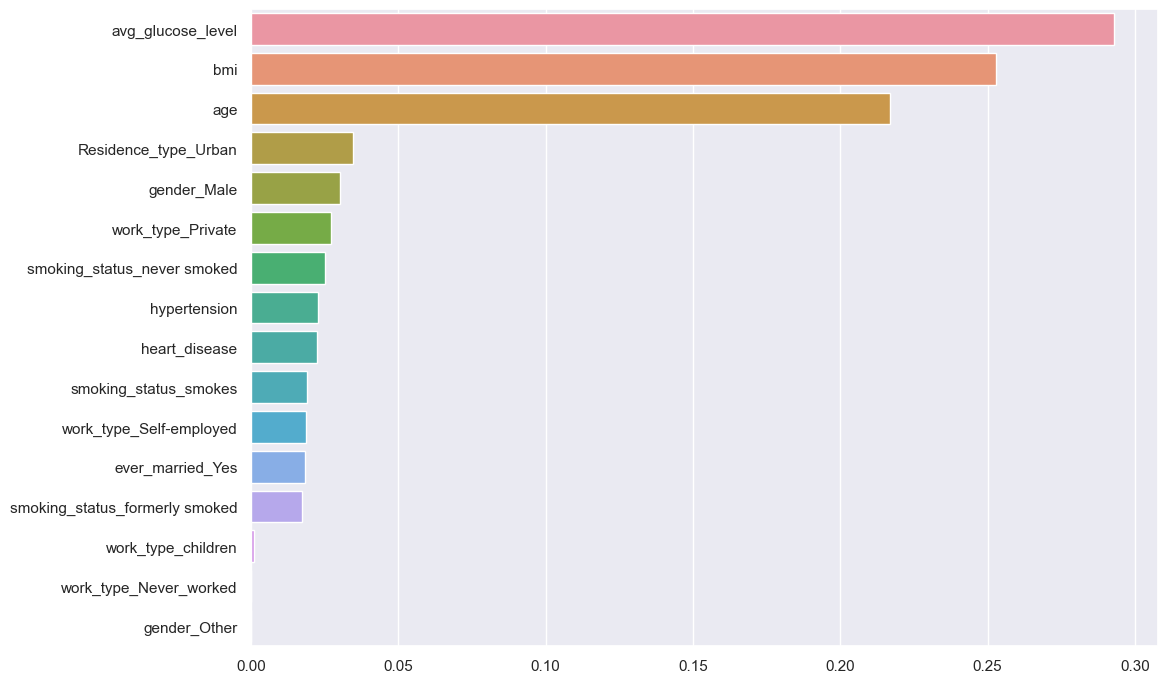

In [22]:

feature_importance_rf = best_rfb.feature_importances_
sorted_features_rf= np.argsort(feature_importance_rf)[::-1]
sorted_feature_names_rf = [feature_names[i] for i in sorted_features_rf]
sorted_importances_rf = feature_importance_rf[sorted_features_rf]

most_important_features_rf = [feature_names[i] for i in sorted_features_rf[:3]]

print("The three most important features are:", most_important_features_rf)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x = sorted_importances_rf, y = sorted_feature_names_rf)



The three most important features are: ['avg_glucose_level', 'bmi', 'age']. Both trees give the same feature importance howevever the orders are different. As I have used one hot encoding the importance for categorical variables is also distributed over different columns. Also worth noting is that other than the top three the order of other variables is different

## Gradient Boosted Trees

Time taken Grid Search of Gradient Boosting Classifier: 41.18581509590149
Best Parameters Gradient Boosting Classifier: {'learning_rate': 4, 'max_depth': 5, 'n_estimators': 25}
Accuracy: 0.7810590631364562
Precision: 0.11210762331838565
Recall: 0.5952380952380952
F1-score 0.18867924528301888


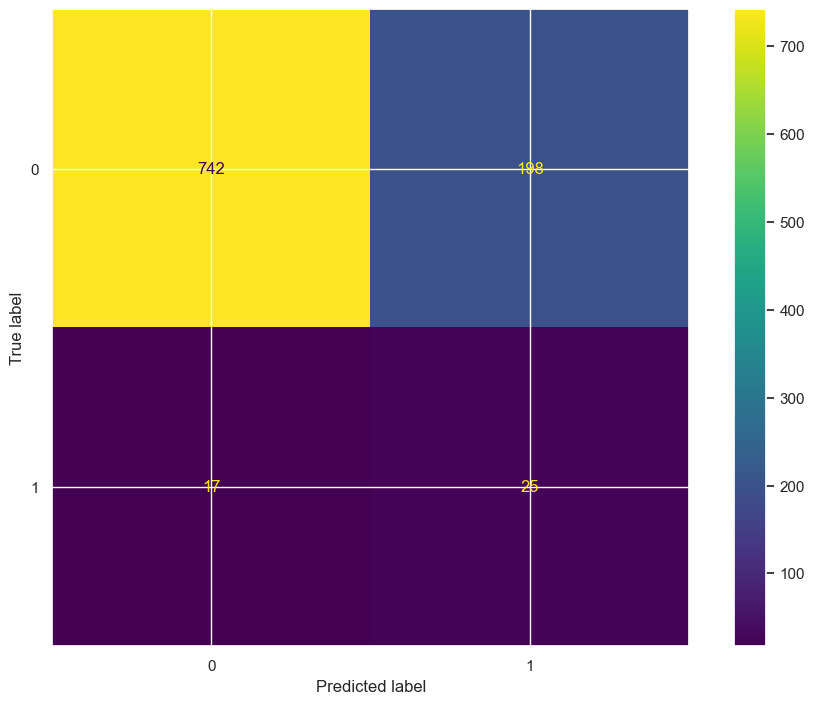

In [23]:
gbc = GradientBoostingClassifier()
hgbc = HistGradientBoostingClassifier()

param_grid_gbc ={
    'learning_rate':[0,1,2,3,4,5],
    'max_depth' : [5,10, 15, 20,25],
    'n_estimators':[25,50,100,150,200],
}
    

grid_search_gbc = GridSearchCV(estimator = gbc, param_grid=param_grid_gbc, n_jobs = -1,cv=5,scoring = 'recall')

start_time_gbc= time.time()
grid_search_gbc.fit(df_X_train, df_y_train)
end_time_gbc = time.time()

time_taken_gbc = end_time_gbc - start_time_gbc
print("Time taken Grid Search of Gradient Boosting Classifier:", time_taken_gbc)

best_parameters_gbc= grid_search_gbc.best_params_
best_gbc = grid_search_gbc.best_estimator_

print("Best Parameters Gradient Boosting Classifier:", best_parameters_gbc)


best_gbc.fit(df_X_train, df_y_train)
gbc_Y_pred = best_gbc.predict(df_X_test)

accuracy_gbc = accuracy_score(df_y_test, gbc_Y_pred)
precision_gbc = precision_score(df_y_test, gbc_Y_pred)
recall_gbc = recall_score(df_y_test, gbc_Y_pred)
f1_score_gbc = f1_score(df_y_test, gbc_Y_pred)

print("Accuracy:", accuracy_gbc)
print("Precision:", precision_gbc)
print("Recall:", recall_gbc)
print("F1-score", f1_score_gbc)

con_gbc = confusion_matrix(df_y_test, gbc_Y_pred)

ConfusionMatrixDisplay(confusion_matrix=con_gbc).plot();

Time taken Grid Search of HIST Gradient Boosting Classifier: 4.123355150222778
Best Parameters  HIST Gradient Boosting Classifier {'learning_rate': 1, 'max_depth': 10, 'max_iter': 25}
Accuracy: 0.7810590631364562
Precision: 0.11210762331838565
Recall: 0.5952380952380952
F1-score 0.18867924528301888


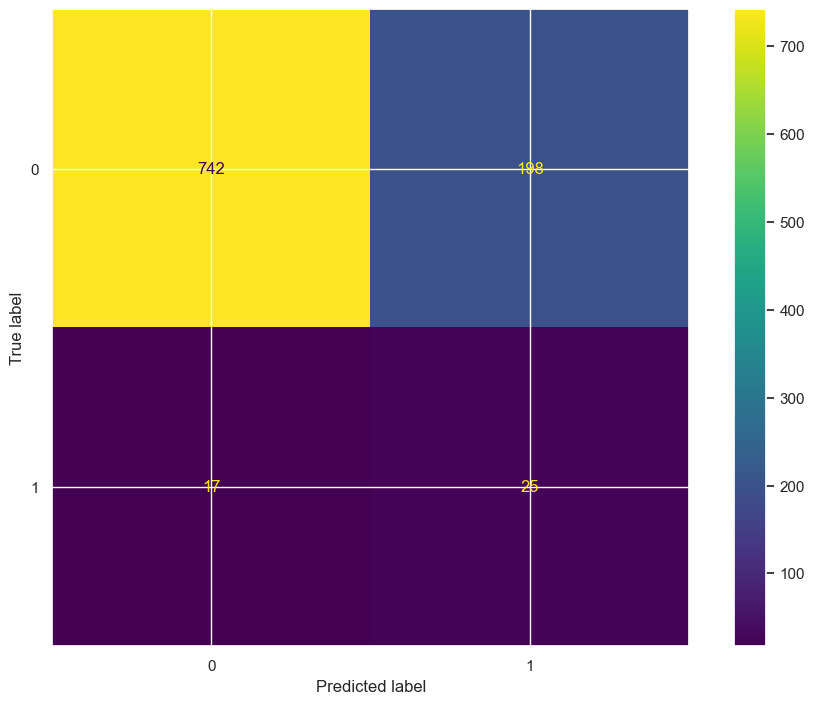

In [24]:
hgbc = HistGradientBoostingClassifier()
param_grid_hgbc ={
    'learning_rate':[0,1,2,3,4,5],
    'max_depth' : [5,10, 15, 20,25],
    'max_iter':[25,50,100,150,200],
}
    

grid_search_hgbc = GridSearchCV(estimator = hgbc, param_grid=param_grid_hgbc,cv=5, n_jobs = -1,scoring = 'recall')

start_time_hgbc= time.time()
grid_search_hgbc.fit(df_X_train, df_y_train)
end_time_hgbc = time.time()

time_taken_hgbc = end_time_hgbc - start_time_hgbc
print("Time taken Grid Search of HIST Gradient Boosting Classifier:", time_taken_hgbc)

best_parameters_hgbc= grid_search_hgbc.best_params_
best_hgbc = grid_search_hgbc.best_estimator_

print("Best Parameters  HIST Gradient Boosting Classifier", best_parameters_hgbc)

best_hgbc.fit(df_X_train, df_y_train)
hgbc_Y_pred = best_gbc.predict(df_X_test)

accuracy_hgbc = accuracy_score(df_y_test, hgbc_Y_pred)
precision_hgbc = precision_score(df_y_test, hgbc_Y_pred)
recall_hgbc = recall_score(df_y_test, hgbc_Y_pred)
f1_score_hgbc = f1_score(df_y_test, hgbc_Y_pred)

print("Accuracy:", accuracy_hgbc)
print("Precision:", precision_hgbc)
print("Recall:", recall_hgbc)
print("F1-score", f1_score_hgbc)

con_hgbc = confusion_matrix(df_y_test, hgbc_Y_pred)

ConfusionMatrixDisplay(confusion_matrix=con_hgbc).plot();

HistGradientSearch takes much less time, almost 1/10 of the time.

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'scale_pos_weight': 9}
Accuracy: 0.8655804480651731
Precision: 0.14285714285714285
Recall: 0.42857142857142855
F1-score: 0.21428571428571427


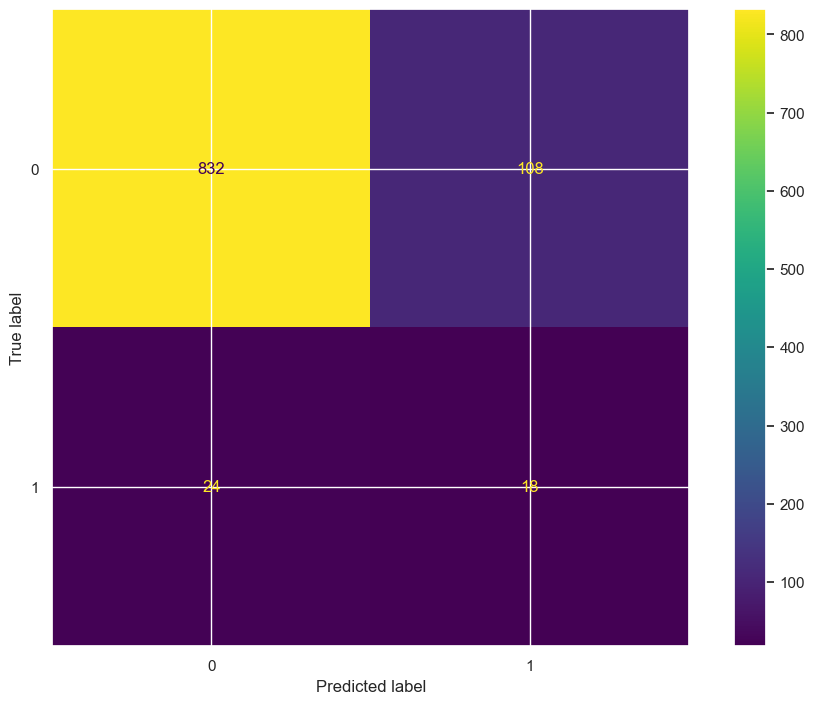

In [25]:
param_grid_xgbc = {
    'max_depth': [5,8,10,12,14],
    'learning_rate': [0.05,0.06,0.1,0.2],
    'scale_pos_weight': [5,6,7,8,9]
}
xgbc = XGBClassifier()
grid_search_xgbc = GridSearchCV(estimator = xgbc, param_grid = param_grid_xgbc, cv = 10, scoring = 'recall', n_jobs = -1)
grid_search_xgbc.fit(df_X_train, df_y_train)
best_parameters_xgbc = grid_search_xgbc.best_params_
best_xgbc = grid_search_xgbc.best_estimator_

print("Best Hyperparameters:", best_parameters_xgbc)

best_xgbc.fit(df_X_train,df_y_train)
best_xgbc_y_pred = best_xgbc.predict(df_X_test)

accuracy_xgbc = accuracy_score(df_y_test, best_xgbc_y_pred)
precision_xgbc = precision_score(df_y_test, best_xgbc_y_pred)
recall_xgbc = recall_score(df_y_test, best_xgbc_y_pred)
f1_score_xgbc = f1_score(df_y_test, best_xgbc_y_pred)

print("Accuracy:", accuracy_xgbc)
print("Precision:", precision_xgbc)
print("Recall:", recall_xgbc)
print("F1-score:", f1_score_xgbc)

con_xgbc = confusion_matrix(df_y_test, best_xgbc_y_pred)

ConfusionMatrixDisplay(confusion_matrix=con_xgbc).plot();

The performance of gradient boosting is better

The three most important features are: ['age', 'heart_disease', 'smoking_status_never smoked']


<Axes: >

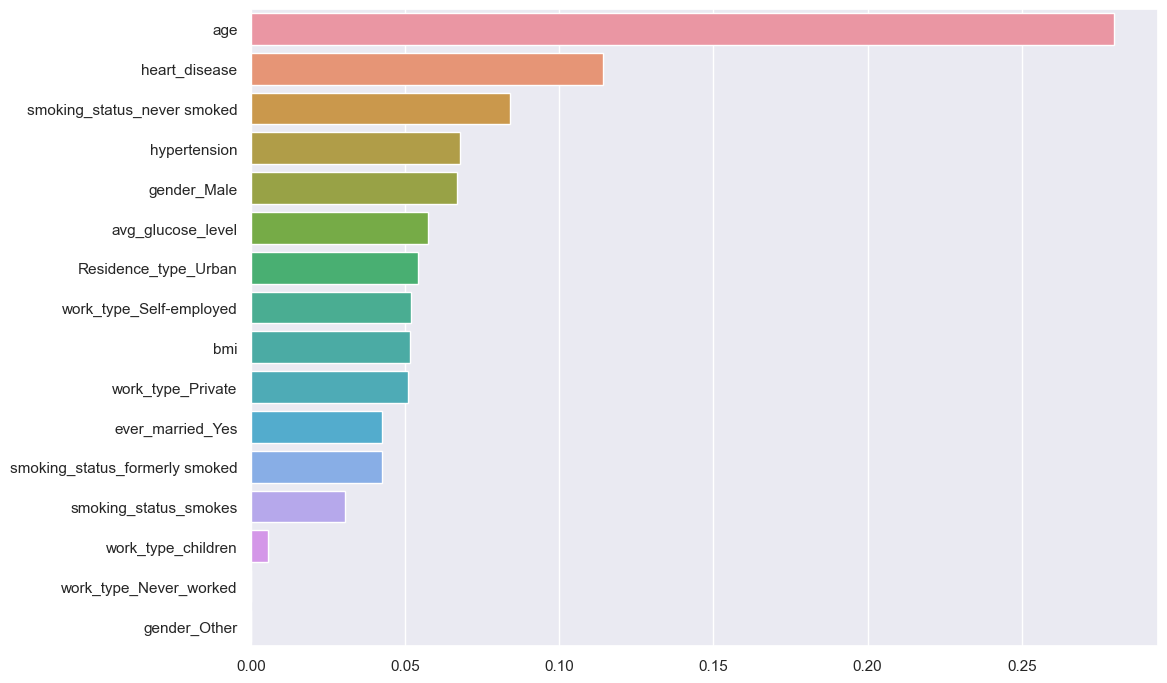

In [26]:
feature_importance_xgbc = best_xgbc.feature_importances_
sorted_features_xgbc= np.argsort(feature_importance_xgbc)[::-1]
sorted_feature_names_xgbc = [feature_names[i] for i in sorted_features_xgbc]
sorted_importances_xgbc = feature_importance_xgbc[sorted_features_xgbc]

most_important_features_xgbc = [feature_names[i] for i in sorted_features_xgbc[:3]]

print("The three most important features are:", most_important_features_xgbc)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x = sorted_importances_xgbc, y = sorted_feature_names_xgbc)


The top three features of decision tree and random Forrest are similar while the top three features of XGBoost is different. I would trust XGBoost the most as it calculates importance based on the number of times a feature is used to split.

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'random_state': 23, 'scale_pos_weight': 9}
Accuracy: 0.8625254582484725
Precision: 0.1450381679389313
Recall: 0.4523809523809524
F1-score: 0.21965317919075147


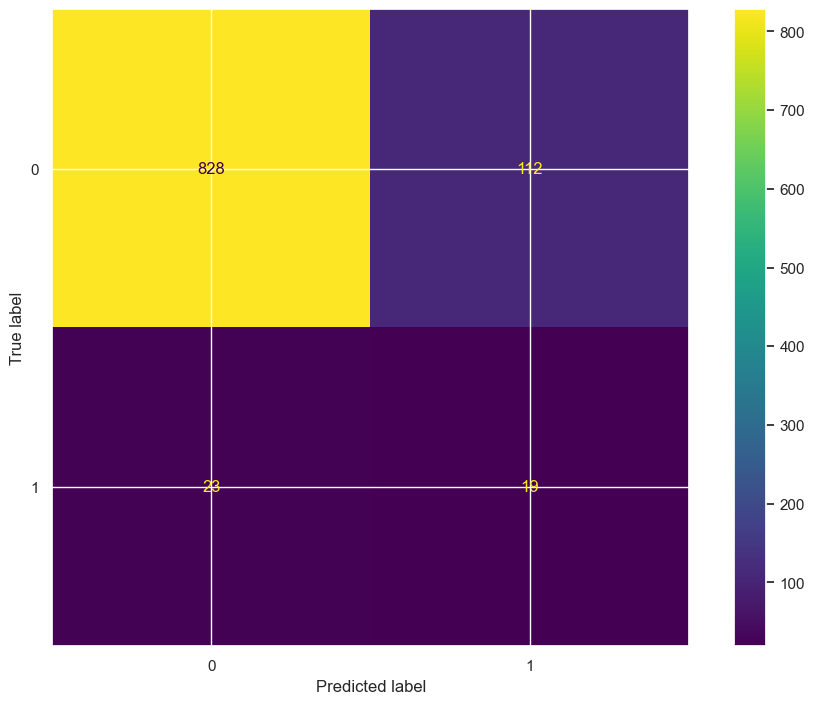

In [27]:

seven_features_xgbc = [feature_names[i] for i in sorted_features_xgbc[:7]]
df_X_train_subset = df_X_train[ seven_features_xgbc ]
df_X_test_subset = df_X_test[ seven_features_xgbc]
param_grid_xgbc_tuned = {
    'max_depth': [5,8,10,12,14],
    'learning_rate': [0.05,0.06,0.1,0.2],
    'scale_pos_weight': [5,6,7,8,9],
    'random_state': [23]
}

xgbc_tuned = XGBClassifier()
grid_search_xgbc_tuned = GridSearchCV(estimator = xgbc_tuned, param_grid = param_grid_xgbc_tuned, cv = 10, scoring = 'recall', n_jobs = -1)
grid_search_xgbc_tuned.fit(df_X_train_subset, df_y_train)
best_parameters_xgbc_tuned= grid_search_xgbc_tuned.best_params_
best_xgbc_tuned = grid_search_xgbc_tuned.best_estimator_
 

print("Best Hyperparameters:", best_parameters_xgbc_tuned)

best_xgbc_tuned.fit(df_X_train_subset,df_y_train)
best_xgbc_y_pred_tuned = best_xgbc_tuned.predict(df_X_test_subset)

accuracy_xgbc_tuned = accuracy_score(df_y_test, best_xgbc_y_pred_tuned)
precision_xgbc_tuned = precision_score(df_y_test, best_xgbc_y_pred_tuned)
recall_xgbc_tuned = recall_score(df_y_test, best_xgbc_y_pred_tuned)
f1_score_xgbc_tuned = f1_score(df_y_test, best_xgbc_y_pred_tuned)

print("Accuracy:", accuracy_xgbc_tuned)
print("Precision:", precision_xgbc_tuned)
print("Recall:", recall_xgbc_tuned)
print("F1-score:", f1_score_xgbc_tuned)

con_xgbc_tuned = confusion_matrix(df_y_test, best_xgbc_y_pred_tuned)

ConfusionMatrixDisplay(confusion_matrix=con_xgbc_tuned).plot();


The performance is slightly better as XGBoost works better with important features

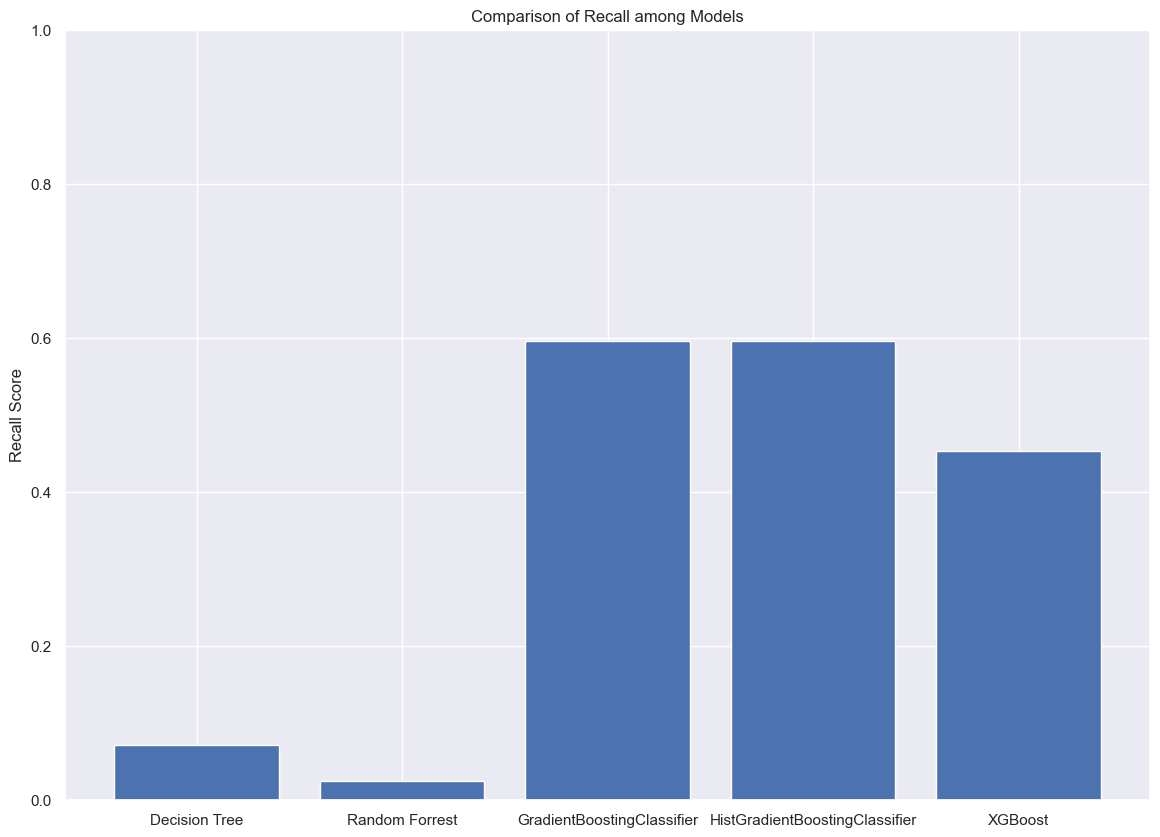

In [28]:
model_names = ["Decision Tree","Random Forrest", "GradientBoostingClassifier", "HistGradientBoostingClassifier","XGBoost"]

Result = {
    "Decision Tree": recall_clf,
    "Random Forrest": recall_rfb,
    "GradientBoostingClassifier": recall_gbc,
    "HistGradientBoostingClassifier":recall_hgbc,
    "XGBoost":recall_xgbc_tuned
}

plt.figure(figsize=(14, 10))
plt.bar(model_names, [Result[model] for model in model_names])
plt.title(f"Comparison of Recall among Models")
plt.ylabel("Recall Score")
plt.ylim(0, 1)  
plt.show()

I would choose the model with the best recall. As HistGradientBoostingClassifier and GradientBoostingClassifier have an equally good recall but HistGradientBoostingClassifier takes less time, I will choose that.

## Calibration

In [29]:

probs = best_xgbc_tuned.predict_proba(df_X_train_subset)
probs = probs[:,1]
brier_score_xgbc = brier_score_loss(df_y_train, probs)


print("Brier Score for XGBoost model:",brier_score_xgbc) #in brier score lower values indicates better performance

Brier Score for XGBoost model: 0.06485279098248999


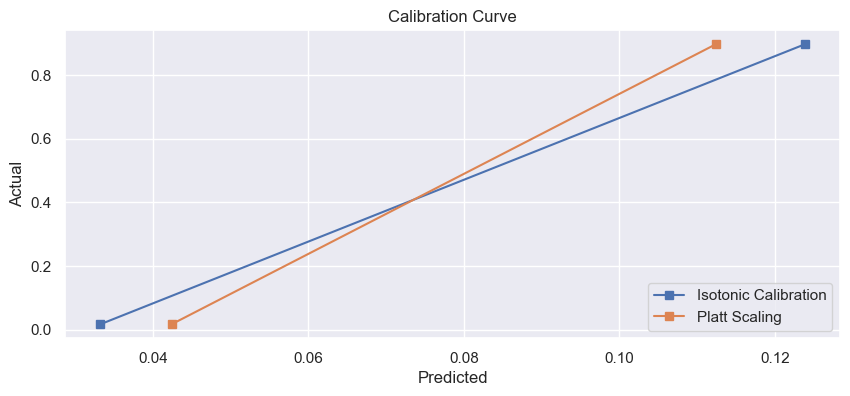

In [30]:

isotonic = CalibratedClassifierCV(base_estimator = best_xgbc_tuned, method = 'isotonic')
isotonic.fit(df_X_test_subset, df_y_test)

platt = CalibratedClassifierCV(base_estimator=best_xgbc_tuned, method = 'sigmoid')
platt.fit(df_X_test_subset, df_y_test)

probs_isotonic = isotonic.predict_proba(df_X_test_subset)[:,1]
probs_platt = platt.predict_proba(df_X_test_subset)[:,1]

plt.figure(figsize=(10,4))
prob_true, prob_pred_isotonic = calibration_curve(df_y_test, probs_isotonic, n_bins=10)
prob_true, prob_pred_platt = calibration_curve(df_y_test, probs_platt, n_bins=10)
plt.plot(prob_pred_isotonic, prob_true, "s-", label="Isotonic Calibration")
plt.plot(prob_pred_platt, prob_true, "s-", label="Platt Scaling")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Calibration Curve')
plt.legend(loc="lower right")
plt.show()

In [31]:
#
brier_score_isotonic = brier_score_loss(df_y_test, probs_isotonic)
brier_score_platt = brier_score_loss(df_y_test, probs_platt)

print("Brier Score (Isotonic):", brier_score_isotonic)
print("Brier Score (Platt Scaling):", brier_score_platt)

Brier Score (Isotonic): 0.03384683349462676
Brier Score (Platt Scaling): 0.03611694972224983


Yes, Calibration methods do help in getting better prediction probablities as lower the brier score, better the model performance.